<a href="https://colab.research.google.com/github/Olesia2288/Yandex_Practice_Data_Science/blob/main/Solving_the_traffic_classification_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорты

In [54]:
!pip install gdown
!pip install scikit-multilearn
!pip install lightgbm
!pip install optuna

In [197]:
import pandas as pd
import numpy as np
import gdown
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder,  FunctionTransformer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
import optuna
import pickle

# Описание проекта

Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления аномального и злонамеренного трафика. Ваша задача - разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный, включая следующие типы атак: DDoS, SQL-инъекции, брутфорс, вредоносные программы и т.д.

# Загрузка и ознакомление с данными

In [128]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
data = pd.read_csv('/content/drive/MyDrive/network_traffic_data.csv')

In [130]:
pd.set_option('display.max_columns', None)

In [131]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,5480074,3,1,12,0,6,0,4.000,3.465,0,0,0.0,0.0,2.189751,0.729917,1.826691e+06,3.131700e+06,5442804,101,5480074,2740037.000,3.822290e+06,5442804,37270,0,0.000,0.00,0,0,0,0,0,0,72,32,0.547438,0.182479,0,6,2.4,3.287,10.8000,0,0,0,1,0,0,0,0,0,3.00,4.000,0.0,72,0,0,0,0,0,0,3,12,1,0,8192,42780,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.100,103.300,1448,0,395.0,587.5,6535.323473,26.686255,3.955428e+04,5.015462e+04,120501,1,616301,77037.625,7.299598e+04,215614,230,616874,68541.555,71985.97,199836,1,0,0,0,0,296,328,12.640858,14.045398,0,1448,232.6,442.800,196012.6600,0,0,0,1,0,0,0,0,1,244.90,78.100,395.0,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.000,0.000,112,112,112.0,0.0,1981.772904,26.075959,5.113267e+04,8.855831e+04,153391,3,3,3.000,0.000000e+00,3,3,4,4.000,0.00,4,4,0,0,0,0,40,40,13.037980,13.037980,40,112,68.8,39.440,1555.2000,0,0,0,0,0,0,0,0,1,86.00,40.000,112.0,40,0,0,0,0,0,0,2,80,2,224,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.000,0.000,128,128,128.0,0.0,3017.689906,34.686091,5.766000e+04,0.000000e+00,57660,57660,0,0.000,0.000000e+00,0,0,0,0.000,0.00,0,0,0,0,0,0,20,20,17.343046,17.343046,46,128,73.3,47.340,2241.3333,0,0,0,0,0,0,0,0,1,110.00,46.000,128.0,20,0,0,0,0,0,0,1,46,1,128,-1,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.336,14.440,6,6,6.0,0.0,63885.267280,5215.123859,2.556667e+02,3.942896e+02,710,3,713,356.500,4.999245e+02,710,3,0,0.000,0.00,0,0,0,0,0,0,60,20,3911.342800,1303.781000,6,31,11.0,11.180,125.0000,0,0,0,0,1,0,0,0,0,13.75,14.336,6.0,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Length Mean       539616 non-nul

Категориальные переменные в датафрейме отсутствуют. Данных 539616 строк, это достаточно большой объем для обучения модели.

Проверим данные на бесконечные значения, для этого выполним код, где такие значения будут заменены на Nan:

In [133]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

Посмотрим, сколько всего пропусков в данных с учетом замененных значений:

In [134]:
data.isnull().sum().sum()

1468

Заполним пропуски автоматическим способом на стадии разделения модели на обучающий и тестовый набор.

In [135]:
data.shape

(539616, 79)

Проверим датасет на дубликаты:

In [136]:
duplicates = data[data.duplicated()]

if duplicates.empty:
    print("Дубликатов в data не найдено.")
else:
    print("Найдены дубликаты в data.")
    print(duplicates.shape)

Найдены дубликаты в data.
(64601, 79)


В данных оказалось много дублирующих значений. Удалим их из датасета:

In [137]:
data = data.drop_duplicates()

In [138]:
data.shape

(475015, 79)

# Исследовательский анализ (EDA)

## Распределение целевого признака

In [139]:
label_counts= data['Label'].value_counts()

In [140]:
label_percentages = (label_counts/len(data)) * 100

In [141]:
label_distribution = pd.DataFrame({'Label': label_counts.index, 'Количество в data': label_counts.values, 'Процент': label_percentages.values})

In [142]:
label_distribution

,Label,Количество в data,Процент
0,BENIGN,232809,49.010873
1,DoS Hulk,87251,18.368052
2,DDoS,64364,13.549888
3,PortScan,56397,11.872678
4,DoS GoldenEye,10286,2.165405
5,FTP-Patator,5933,1.249013
6,DoS slowloris,5385,1.133648
7,DoS Slowhttptest,5228,1.100597
8,SSH-Patator,3219,0.677663
9,Bot,1953,0.411145


Всего у нас 15 лейблов для входящего трафика. Целевой признак разспределен неравномерно, больше всего сведений в датасете о BENIGN (нормальном трафике), таких данных почти 50%. Большинство остальных лейблов составляет в датасете всего 1-10%, есть метки трафика, которых в датасете совсем незначительное количество (менее 0,01%) - это Infiltration, Web Attack � Sql Injection, Heartbleed.

## Уменьшение размерности (PCA)

В датасете 78 признаков, их проанализировать и выявить в них закономерности практически невозможно, необходимо уменьшить размер данных. Можно это сделать с помощью PCA. Этот метод позволяет не только сократить размерность данных, но и улучшенить производительности алгоритмов машинного обучения, а также устраненить мультиколлинеарности: PCA может использоваться для устранения мультиколлинеарность.

Для начала необходимо определить количество компанент, сделает это с помощью метода "локтя":

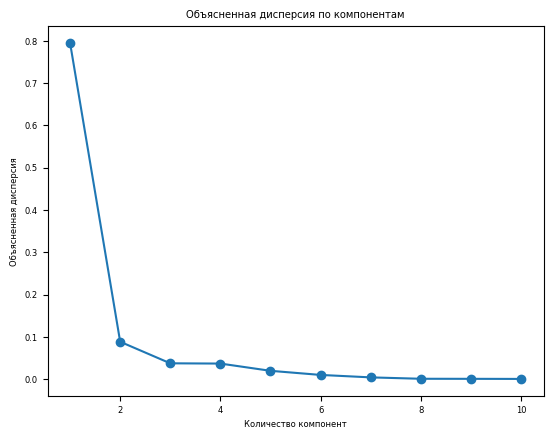

In [144]:
num_components = 10
pca = PCA(n_components=num_components)

# Применим PCA к данным
pca_result = pca.fit_transform(data.dropna().drop('Label', axis=1))

# Получаем объясненную дисперсию для каждой компоненты
explained_variance = pca.explained_variance_ratio_

# Визуализация:
import matplotlib.pyplot as plt
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Количество компонент')
plt.ylabel('Объясненная дисперсия')
plt.title('Объясненная дисперсия по компонентам')
plt.show()


Это значит, что с использованием первых двух главных компонентов (PC1 и PC2) сохраняется 90% информации из исходных данных, потеря составит 10% информации. Чтоб сохранить 95% данных можно выбрать 3 компоненты.

# Baseline

## Распределение на целевой признак и фичи

In [153]:
X = data.drop('Label', axis = 1)

In [154]:
y = data['Label']

Заполним пропущенные значения:

In [155]:
imputer = SimpleImputer(strategy='median')

In [156]:
X_imputed = imputer.fit_transform(X)

Закодируем целевой признак:

In [157]:
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

In [161]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_imputed, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

In [162]:
X_train_val.shape

(380012, 78)

In [163]:
X_test.shape

(95003, 78)

Разделяем данные на обучающий и валидационный наборы:

In [164]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val,
                                                      random_state=42)

In [165]:
X_train.shape

(304009, 78)

In [166]:
X_valid.shape

(76003, 78)

## Обучение

Используем простую линейную модель:

In [167]:
# стандартизация признаков для линейной модели
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [168]:
base_model = LogisticRegression()
base_model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [169]:
y_pred = base_model.predict(X_valid_scaled)

In [170]:
y_pred_decoded = label_encoder.inverse_transform(y_pred)

In [171]:
y_valid_decoded = label_encoder.inverse_transform(y_valid)

In [172]:
accuracy = accuracy_score(y_valid_decoded, y_pred_decoded)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_valid_decoded, y_pred_decoded))


Accuracy: 0.96


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.98      0.95      0.96     37250
                       Bot       0.67      0.03      0.05       312
                      DDoS       0.99      1.00      0.99     10298
             DoS GoldenEye       0.97      0.89      0.93      1646
                  DoS Hulk       0.95      1.00      0.97     13960
          DoS Slowhttptest       0.92      0.89      0.91       837
             DoS slowloris       0.89      0.89      0.89       862
               FTP-Patator       0.88      0.99      0.93       949
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.17      0.29         6
                  PortScan       0.92      1.00      0.96      9024
               SSH-Patator       0.98      0.92      0.95       515
  Web Attack � Brute Force       0.00      0.00      0.00       235
Web Attack � Sql Injection       0.00      0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Есть классы, которые модель определяет очень хорошо. Общая точность модели говорит о том, что 97% трафика идентифицировано верно. Но есть классы, которые модель не может определить, например Web Attack � Sql Injection, Web Attack � XSS, Web Attack � Brute Forc.

Можно попробовать более сложные модели, например бустинговые.

# Моделирование

## Бустинговые модели

### XGBClassifier

In [173]:
xgb_model = xgb.XGBClassifier()

In [174]:
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [175]:
y_pred = xgb_model.predict(X_valid_scaled)

In [176]:
y_pred_decoded = label_encoder.inverse_transform(y_pred)

In [177]:
y_valid_decoded = label_encoder.inverse_transform(y_valid)

In [178]:
accuracy = accuracy_score(y_valid_decoded, y_pred_decoded)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_valid_decoded, y_pred_decoded))

Accuracy: 1.00
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     37250
                       Bot       0.96      0.98      0.97       312
                      DDoS       1.00      1.00      1.00     10298
             DoS GoldenEye       1.00      1.00      1.00      1646
                  DoS Hulk       1.00      1.00      1.00     13960
          DoS Slowhttptest       1.00      0.99      1.00       837
             DoS slowloris       1.00      1.00      1.00       862
               FTP-Patator       1.00      1.00      1.00       949
                Heartbleed       1.00      0.50      0.67         2
              Infiltration       1.00      0.33      0.50         6
                  PortScan       1.00      1.00      1.00      9024
               SSH-Patator       1.00      1.00      1.00       515
  Web Attack � Brute Force       0.74      0.82      0.78       235
Web Attack � Sql Injection      

### LGBMClassifier()

In [179]:
lgb_model = lgb.LGBMClassifier(verbose=-1)

In [180]:
lgb_model.fit(X_train_scaled, y_train)

LGBMClassifier(verbose=-1)

In [181]:
y_pred = lgb_model.predict(X_valid_scaled)

In [182]:
y_pred_decoded = label_encoder.inverse_transform(y_pred)

In [183]:
y_valid_decoded = label_encoder.inverse_transform(y_valid)

In [184]:
accuracy = accuracy_score(y_valid_decoded, y_pred_decoded)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_valid_decoded, y_pred_decoded))

Accuracy: 0.68
                            precision    recall  f1-score   support

                    BENIGN       0.81      0.78      0.79     37250
                       Bot       0.15      0.19      0.17       312
                      DDoS       0.59      0.73      0.65     10298
             DoS GoldenEye       0.00      0.00      0.00      1646
                  DoS Hulk       0.70      0.60      0.65     13960
          DoS Slowhttptest       0.65      0.07      0.13       837
             DoS slowloris       0.00      0.00      0.00       862
               FTP-Patator       0.08      0.01      0.01       949
                Heartbleed       0.00      0.00      0.00         2
              Infiltration       0.00      0.00      0.00         6
                  PortScan       0.61      0.79      0.68      9024
               SSH-Patator       0.00      0.00      0.00       515
  Web Attack � Brute Force       0.00      0.00      0.00       235
Web Attack � Sql Injection      

Бустинговая модель XGB показала очень хороший результат. Модель имеет высокую общую точность и хорошие оценки для большинства классов. Может определять все классы, в том числе "Infiltration", "Web Attack - Brute Force", "Web Attack - Sql Injection" и "Web Attack - XSS".

In [185]:
def objective(trial):

    # гиперпараметры, включая регуляризацию
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),  # L1 регуляризация
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),  # L2 регуляризация
           }

    model = xgb.XGBClassifier(**params)

    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

    accuracy = cv_scores.mean()

    return accuracy


In [187]:
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=5)

#best_params = study.best_params
#best_accuracy = study.best_value

#print("Best Parameters:", best_params)
#print("Best Accuracy:", best_accuracy)

[I 2023-10-05 02:56:32,818] A new study created in memory with name: no-name-fa78fa5c-595a-439c-81a4-b9f7c33b8d1f
[I 2023-10-05 03:19:36,361] Trial 0 finished with value: 0.9974902056439119 and parameters: {'n_estimators': 196, 'learning_rate': 0.06314927318149223, 'max_depth': 10, 'reg_alpha': 0.7427979484172919, 'reg_lambda': 0.6029907764032397}. Best is trial 0 with value: 0.9974902056439119.
[I 2023-10-05 03:25:30,565] Trial 1 finished with value: 0.9970757440243407 and parameters: {'n_estimators': 71, 'learning_rate': 0.07071792842034759, 'max_depth': 6, 'reg_alpha': 0.8784721181215848, 'reg_lambda': 0.08396877353719201}. Best is trial 0 with value: 0.9974902056439119.
[I 2023-10-05 03:43:16,080] Trial 2 finished with value: 0.9975395465589368 and parameters: {'n_estimators': 224, 'learning_rate': 0.060638347914234975, 'max_depth': 4, 'reg_alpha': 0.06497651703028373, 'reg_lambda': 0.40917338574733375}. Best is trial 2 with value: 0.9975395465589368.
[I 2023-10-05 04:10:25,013] Tr

Best Parameters: {'n_estimators': 245, 'learning_rate': 0.06469661712354244, 'max_depth': 7, 'reg_alpha': 0.4167410533929089, 'reg_lambda': 0.780522343316105}
Best Accuracy: 0.9975658611040845


Собираем готовую модель:

In [188]:
best_model = xgb.XGBClassifier(n_estimators = 245, learning_rate = 0.06469661712354244,
                               max_depth=7, reg_alpha = 0.4167410533929089,
                               reg_lambda = 0.780522343316105)

# Тестирование модели

X_test является не стандантизированным набором, выполним его стандартизацию:

In [189]:
# Cоздаем пайплайн
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Стандартизация данных
    ('classifier', best_model)
])

In [190]:
pipeline.fit(X_train_val, y_train_val)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.06469661712354244, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=245,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [191]:
y_pred = pipeline.predict(X_test)

In [192]:
y_pred_decoded = label_encoder.inverse_transform(y_pred)

In [193]:
y_test_decoded = label_encoder.inverse_transform(y_test)

In [194]:
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test_decoded, y_pred_decoded))

Accuracy: 1.00
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     46562
                       Bot       0.95      0.99      0.97       391
                      DDoS       1.00      1.00      1.00     12873
             DoS GoldenEye       1.00      1.00      1.00      2057
                  DoS Hulk       1.00      1.00      1.00     17450
          DoS Slowhttptest       1.00      1.00      1.00      1046
             DoS slowloris       1.00      0.99      0.99      1077
               FTP-Patator       1.00      1.00      1.00      1187
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.71      0.83         7
                  PortScan       1.00      1.00      1.00     11279
               SSH-Patator       1.00      1.00      1.00       644
  Web Attack � Brute Force       0.72      0.91      0.81       294
Web Attack � Sql Injection      

Матрица ошибок:

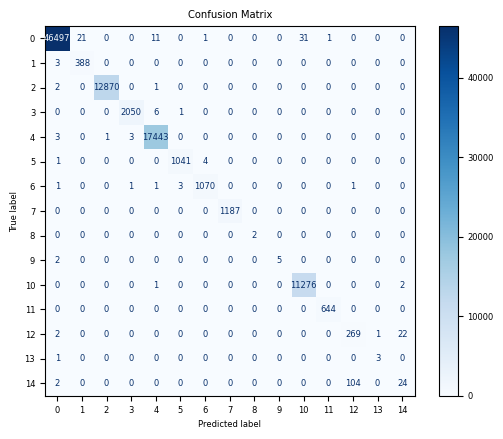

In [195]:
confusion = confusion_matrix(y_test_decoded, y_pred_decoded)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Удалось улучшить метрики практически по всем классам, в базовой модели некоторые классы не могли быть определены, после выбора бустинговой модели и с учетом подбора гиперпараметров удалось определить все классы, но Web Attack � XSS  всё еще плохо определяется, из 130 экземпляров только 24 определено верно, 104 экземпляра определены как Web Attack � Brute Force, а 2 экземплярам присвоен лейбл нормального класса. Ошибка первого рода - когда угроза признана нормальным трафиком - встречается давольно часто, это оносится к следующим классам - Bot (3 экземпляра), DDoS (2 экземпляра), DoS Hulk (3 экземпляра), DoS Slowhttptest (1 экземпляр),  DoS slowloris (1 экземпляр), Infiltration (2 экземпляра), Web Attack � Brute Force (2 экземпляра), Web Attack � Sql Injection (1 экземпляр) и Web Attack � XSS (2 экземпляра).  

# Отчет по проекту:

*Задача проекта* - разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный, включая следующие типы атак: DDoS, SQL-инъекции, брутфорс, вредоносные программы и т.д.

В ходе проекта данные были загружены и исследованы. В датафрейме оказалось 78 признаков и 15 разновидностей трафика. Объем данных для исследования на мультиколленеарность и аномалии оказался слишком велик, при этом всего две компанеты оправдывают 90% дисперсии в данных.

В ходе работы над проектом была *проведена первичная предобработка данных*:
- обнаружены бесконечные значения и заменены на Nan
- пропуски в данных, в том числе замененные бесконечные значения заполняем автоматически с помощью SimpleImputer(strategy='median')
- все признаки в датасете числовые, выполняем стандартизацию StandardScaler()

*Исследованы три модели*:
- в качестве базовой модели была выбрана простая логистическа регрессия, модель определила верно 96% трафика.
- также попробованы более сложные модели - бустинговые: XGBClassifier (точность модели - 1,00) и LGBMClassifier (точность модели - 0,68).
В итоге была выбрана модель - XGBClassifier, поскольку модель является довольно легкой, то уменьшать размерность данных не понадобилось. При выборе более сложной модели, например catboost лучше предварительно выполнить РСА с количеством главных компанент = 2, что может значительно упростить работу модели.

*Модель была улучшена с помощью подбора гиперпараметров*:

**best_model = xgb.XGBClassifier(n_estimators = 335, learning_rate = 0.07772503452577982, max_depth=5, reg_alpha = 0.8804473627587581,  reg_lambda = 0.2693312272969641)**

В итоге точность модели на кросс-валидации составила 0,9975. Ошибка первого рода - угроза признана нормальным трафиком - встречается давольно часто, это оносится к следующим классам - Bot (3 экземпляра), DDoS (2 экземпляра), DoS Hulk (3 экземпляра), DoS Slowhttptest (1 экземпляр),  DoS slowloris (1 экземпляр), Infiltration (2 экземпляра), Web Attack � Brute Force (2 экземпляра), Web Attack � Sql Injection (1 экземпляр) и Web Attack � XSS (2 экземпляра).

**В результате работы были получены следующие файлы:**

In [198]:
# Модель
with open('model_for_web_attack.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

# Энкодер
with open('encoder_for_web_attack.pkl', 'wb') as encoder_file:
    pickle.dump(label_encoder, encoder_file)

**Полный пайплайн для обработки новых входящих данных:**

- создаем пайплайн для предобработки данных

In [199]:
pipeline = Pipeline([
    ('replace_inf', FunctionTransformer(lambda X: np.where(np.isinf(X), np.nan, X))),  # Замена бесконечных значений на NaN
    ('scaler', StandardScaler()),  # Стандартизация данных
    ('imputer', SimpleImputer(strategy='median'))  # Обработка пропусков с помощью медианных значений
])

- преобразования новых данных

new_data_processed = pipeline.fit_transform(new_data)

- применение обученной модели

predictions = best_model.predict(new_data_processed)